In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection as fs
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('epi_r.csv') as f:
    df = pd.read_csv(f)

In [4]:
df.shape

(20052, 680)

### Задача: обучить модель предсказывать рэйтинг блюда

Необходимо сделать следующие шаги:

1) Сделать что-то с пропусками(выбросить или заполнить чем либо)

2) Сделать что-то с дубликатами

3) Проверсти препроцессинг(выделить факторы, нормальзовать факторы)

4) Попробовать добваить новые факторы на основе имеющихся

5) Обучить модель и проверить результаты на тестовой выборке(изначально нужно разделить на тестовыю и обучающуюся)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


#### Из описания видно, что только один столбец содержит в себе строки, а остальные столбцы - числа

In [6]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train, df_test = model_selection.train_test_split(df)

In [8]:
df_train.shape, df_test.shape

((15039, 680), (5013, 680))

In [9]:
sum(df_train.isna().sum() > 0)

4

In [10]:
df_train.isna().sum().sort_values()[-4:]

calories    3097
sodium      3099
protein     3132
fat         3151
dtype: int64

#### calories, protein, fat, sodium -  имеют пропущенные значения

In [11]:
col_with_nan = ['calories', 'protein', 'fat', 'sodium']

### Определим выбросы

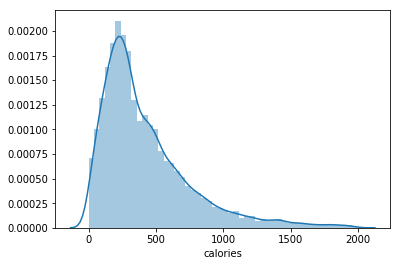

In [12]:
sns.distplot(df_train.calories[df_train.calories < 2000].dropna())

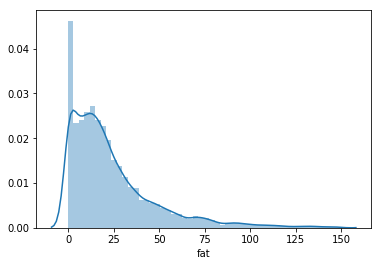

In [13]:
sns.distplot(df_train.fat[df_train.fat < 150].dropna())

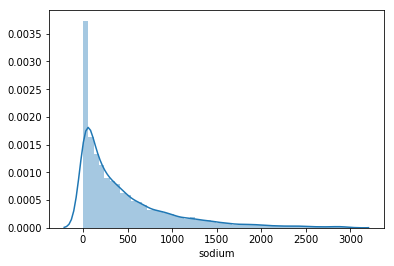

In [14]:
sns.distplot(df_train.sodium[df_train.sodium < 3000].dropna())

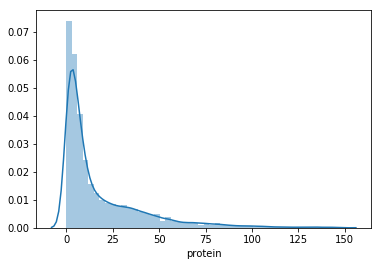

In [15]:
sns.distplot(df_train.protein[df_train.protein < 150].dropna())

Выпишем границу для каждой колонки, значения выше которой мы будем принимать за выбросы

In [16]:
treshholds = [
    ('calories', 2000),
    ('sodium', 3000),
    ('fat', 150),
    ('protein', 150)
]

In [17]:
df_train.shape

(15039, 680)

Удалим выбросы

In [18]:
for col, val in treshholds:
    df_train = df_train[df_train[col] < val]

In [19]:
df_train.shape

(11355, 680)

Заполним все Nan средним значением по каждой колонке

In [20]:
df_train = df_train.fillna(df_train.mean())

In [21]:
df_train.isna().sum().sum()

0

In [22]:
df_train.head(3)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
3468,Pork and Sausage SautГ©,4.375,1183.0,63.0,44.0,2178.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480,Mozzarella Pesto Spread,3.750,312.0,14.0,27.0,624.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19793,Herby Barley Salad With Butter-Basted Mushrooms,4.375,265.0,6.0,19.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Удалим название блюд, так как они не несут полезной информации

In [23]:
df_train = df_train.drop('title', axis=1)

In [24]:
X = df_train.drop('rating', axis=1)
y = df_train.rating

In [25]:
lr = linear_model.LinearRegression()
lr.fit(X.values, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
lr.predict(X)

array([4.01354677, 3.76250296, 4.30486998, ..., 4.27621964, 3.83162971,
       3.58166493])

In [28]:
metrics.mean_squared_error(y, lr.predict(X))

1.284365668610451

In [63]:
from sklearn import feature_selection

In [75]:
print(X.shape)
print(feature_selection.VarianceThreshold(.01).fit_transform(X).shape)

(11355, 678)
(11355, 203)


In [72]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [83]:
all_losses = []

for k in range(5, 120, 5):
    X_kbest = feature_selection.SelectKBest(
        feature_selection.f_classif, 
        k=k,
    ).fit_transform(
        X,
        y,
    )
    lr = linear_model.LinearRegression()
    standart_scaler = preprocessing.StandardScaler()
    loss = model_selection.cross_val_score(
        lr, 
        standart_scaler.fit_transform(X_kbest),
        y, 
        scoring='neg_mean_absolute_error'
    ).mean()
    print(f"k = {k} neg_log_loss = {loss}")
    all_losses.append(loss)

k = 5 neg_log_loss = -0.8276993141429517
k = 10 neg_log_loss = -0.8230478988384968
k = 15 neg_log_loss = -0.8229226904445522
k = 20 neg_log_loss = -0.823294174401584
k = 25 neg_log_loss = -0.825893201000016
k = 30 neg_log_loss = -0.8246280653926474
k = 35 neg_log_loss = -0.8246338720969844
k = 40 neg_log_loss = -0.8241021372778453
k = 45 neg_log_loss = -0.8218846404979575
k = 50 neg_log_loss = -0.8191782035261882
k = 55 neg_log_loss = -0.8189899825380168
k = 60 neg_log_loss = -0.8155969597455573
k = 65 neg_log_loss = -0.8139541763671772
k = 70 neg_log_loss = -0.8142825472976339
k = 75 neg_log_loss = -0.8129058925160715
k = 80 neg_log_loss = -0.8118720564777684
k = 85 neg_log_loss = -0.8099858884970716
k = 90 neg_log_loss = -0.8101864668261527
k = 95 neg_log_loss = -0.810792474474129
k = 100 neg_log_loss = -43248762882.63778
k = 105 neg_log_loss = -1473570050.0205252
k = 110 neg_log_loss = -15195002665.256697
k = 115 neg_log_loss = -46198722176.74426


In [39]:
scaler = preprocessing.StandardScaler()

In [52]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [53]:
X_norm = scaler.transform(X)

In [58]:
X_norm[:,2:3]

array([[ 0.90939822],
       [ 0.17264093],
       [-0.17406838],
       ...,
       [-0.34742304],
       [ 0.51935025],
       [ 0.04262494]])

In [60]:
lr1 = linear_model.LinearRegression()
lr1.fit(X_norm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
metrics.mean_squared_error(y, lr1.predict(X_norm))

1.2975451617541065